## 1. Import Required Libraries
Import torch, torchvision, matplotlib, and other required libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import random

manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Check if GPU is being used
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2060
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB


## 2. Load and Preprocess MNIST Dataset
Download the MNIST dataset using torchvision, apply necessary transforms, and create DataLoader objects.

In [4]:
batch_size = 512
image_size = 28
channels = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## 3. Define Generator Network
Implement the Generator class using torch.nn.Module, specifying layers and forward method.

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256, momentum=0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512, momentum=0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024, momentum=0.2),
            nn.Linear(1024, image_size * image_size * channels),
            nn.Tanh()
        )
        self.latent_dim = latent_dim
    def forward(self, z):
        out = self.model(z)
        out = out.view(z.size(0), channels, image_size, image_size)
        return out

## 4. Define Discriminator Network
Implement the Discriminator class using torch.nn.Module, specifying layers and forward method.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

## 5. Initialize Networks and Optimizers
Instantiate generator and discriminator models, define loss function, and set up optimizers.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## 6. Training Loop for GAN
Write the training loop to alternately train the discriminator and generator, logging losses.

In [8]:
def sample_images(gen_imgs,epoch):
    # r, c = 5, 5
    # noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    # gen_imgs = self.generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(4,4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [9]:
# --- GAN Training Loop with improvements ---
d_losses = []
g_losses = []
fixed_z = torch.rand(16, latent_dim, device=device)  # For consistent evaluation
sample_images = []

epochs = 100
for epoch in range(epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.to(device, non_blocking=True)  # Efficient transfer
        batch_size = real_imgs.size(0)
        
        # Generate fake images
        z = torch.rand(batch_size, latent_dim, device=device)
        fake_imgs = generator(z).detach()  # Detach to avoid gradient tracking
        
        # 1. Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        outputs_real = discriminator(real_imgs)
        outputs_fake = discriminator(fake_imgs)
        
        d_loss_real = criterion(outputs_real, real_labels)  # Original criterion
        d_loss_fake = criterion(outputs_fake, fake_labels)  # Original criterion
        
        
        
        optimizer_D.zero_grad()
        d_loss_real.backward()
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()
        d_loss_epoch += d_loss.item()
        
        # 2. Train Generator
        z = torch.rand(batch_size, latent_dim, device=device)  # Regenerate z for generator
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs)
        g_loss = criterion(outputs_fake, real_labels)  # Original criterion
        # g_loss = torch.log(outputs_fake + 1e-8).mean()  # Log-based loss
        
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        g_loss_epoch += g_loss.item()
    
    d_losses.append(d_loss_epoch / len(train_loader))
    g_losses.append(g_loss_epoch / len(train_loader))
    
    # 3. Save generated images with fixed z for each epoch
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(fixed_z).cpu()  # Move to CPU for visualization
        sample_images.append(fake_samples)
    generator.train()
    
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss_epoch/len(train_loader):.4f}  G_loss: {g_loss_epoch/len(train_loader):.4f}")
    
# 4. Save model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(generator.state_dict(), 'checkpoints/generator.pth')
torch.save(discriminator.state_dict(), 'checkpoints/discriminator.pth')

Epoch [1/100]  D_loss: 0.5464  G_loss: 1.2371
Epoch [2/100]  D_loss: 0.8668  G_loss: 0.9635
Epoch [3/100]  D_loss: 1.0597  G_loss: 0.9225
Epoch [4/100]  D_loss: 1.2427  G_loss: 0.8601
Epoch [5/100]  D_loss: 1.2814  G_loss: 0.8408
Epoch [6/100]  D_loss: 1.3115  G_loss: 0.8081
Epoch [7/100]  D_loss: 1.3234  G_loss: 0.8051
Epoch [8/100]  D_loss: 1.2937  G_loss: 0.8353
Epoch [9/100]  D_loss: 1.2876  G_loss: 0.8439
Epoch [10/100]  D_loss: 1.2815  G_loss: 0.8568
Epoch [11/100]  D_loss: 1.2748  G_loss: 0.8696
Epoch [12/100]  D_loss: 1.2768  G_loss: 0.8613
Epoch [13/100]  D_loss: 1.2584  G_loss: 0.8867
Epoch [14/100]  D_loss: 1.2700  G_loss: 0.8758
Epoch [15/100]  D_loss: 1.2930  G_loss: 0.8415
Epoch [16/100]  D_loss: 1.2913  G_loss: 0.8425
Epoch [17/100]  D_loss: 1.2989  G_loss: 0.8248
Epoch [18/100]  D_loss: 1.3146  G_loss: 0.7939
Epoch [19/100]  D_loss: 1.3216  G_loss: 0.8026
Epoch [20/100]  D_loss: 1.3249  G_loss: 0.7840
Epoch [21/100]  D_loss: 1.3246  G_loss: 0.7905
Epoch [22/100]  D_loss

KeyboardInterrupt: 

## 7. Generate and Visualize Samples
Use the trained generator to produce fake MNIST images and visualize them using matplotlib.

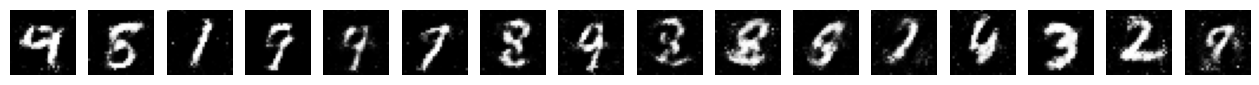

In [10]:
generator.eval()
# z = torch.randn(16, latent_dim).to(device)

fake_imgs = generator(fixed_z).cpu().detach()
fake_imgs = fake_imgs * 0.5 + 0.5  # Rescale to [0, 1] if using Tanh
fig, axes = plt.subplots(1, 16, figsize=(16, 2))
for i in range(16):
    axes[i].imshow(fake_imgs[i][0], cmap='gray')
    axes[i].axis('off')
plt.show()

## 8. Calculate FID Score
We will use the `torchmetrics` library to calculate the FID (Fréchet Inception Distance) score between generated images and real MNIST images. If not installed, run `pip install torchmetrics`.

In [11]:
# If torchmetrics is not installed, uncomment the next line:
# !pip install torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid
from torchmetrics.image.inception import InceptionScore


# Prepare real and fake images for FID calculation
fid = FrechetInceptionDistance(feature=64).to(device)
inception = InceptionScore().to(device)


# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:128].to(device)
real_imgs = real_imgs.repeat(1, 3, 1, 1)  # Convert to 3 channels for FID

# Generate a batch of fake images
z = torch.randn(128, latent_dim).to(device)
fake_imgs = generator(z)
fake_imgs = fake_imgs.repeat(1, 3, 1, 1)  # Convert to 3 channels for FID

real_imgs_uint8 = (real_imgs * 255).clamp(0, 255).to(torch.uint8)
fake_imgs_uint8 = (fake_imgs * 255).clamp(0, 255).to(torch.uint8)

fid.update(real_imgs_uint8, real=True)
fid.update(fake_imgs_uint8, real=False)
fid_score = fid.compute().item()
print(f"FID score: {fid_score:.2f}")

inception.update(fake_imgs_uint8)
inception_score = inception.compute()
print(f"Inception Score: {inception_score[0]:.4f}")



c:\Users\home\miniconda3\envs\py311\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID score: 0.18
Inception Score: 1.9313


## Loss Curve Visualization
Discriminator와 Generator의 loss 변화를 그래프로 확인합니다.

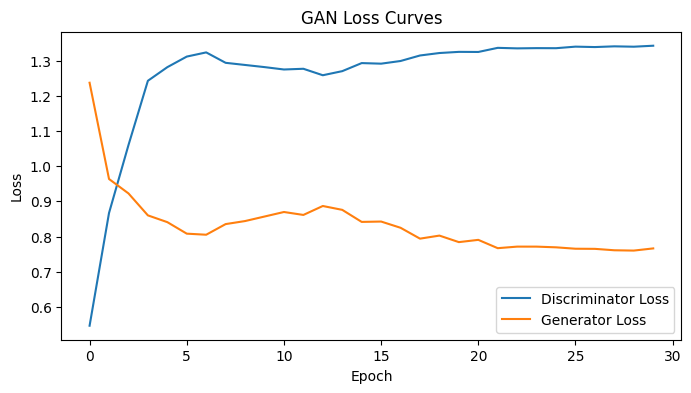

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss Curves')
plt.show()

## Fixed z로 생성된 이미지 시각화
에폭별로 고정된 z에서 생성된 이미지를 시각화하여 발전 과정을 확인합니다.

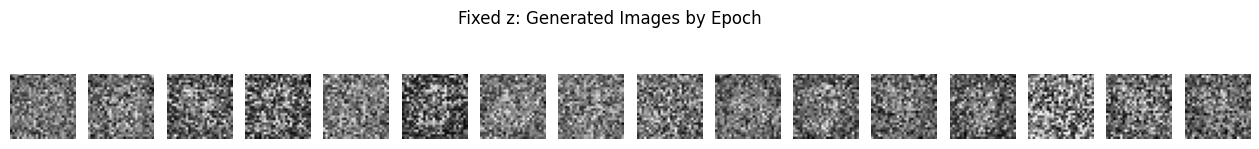

In [13]:
# 에폭별로 고정 z에서 생성된 이미지 시각화
n_epochs_to_show = len(sample_images)//25
plt.figure(figsize=(16, 2 * n_epochs_to_show))
for i in range(n_epochs_to_show):
    imgs = sample_images[10*i]
    for j in range(16):
        plt.subplot(n_epochs_to_show, 16, i * 16 + j + 1)
        plt.imshow(imgs[j][0], cmap='gray')
        plt.axis('off')
plt.suptitle('Fixed z: Generated Images by Epoch')
plt.show()